<h1>Use ODM2API to connect to an ODM2 database, create a dropdownlist to pick a time series and visualize them</h1>
<p>1) First load standard python libraries</p>

In [36]:
%matplotlib inline

import sys
import os
import pprint
import numpy
import getpass
import matplotlib.pyplot as plt
from matplotlib.dates import DateFormatter
from IPython.display import display, HTML
import ipywidgets as widgets

<p>2) Next load odm2api components we will use </p>

In [37]:
from odm2api.ODMconnection import dbconnection
import odm2api.ODM2.services.readService as odm2
from odm2api.ODM2.models import *

<p>3) now connect to the database and instantiate the read service </p>

In [38]:
#print("Enter your ODM2 username") 
container = widgets.Box() # would be nice If I could get a container to hold the 
# user name and password prompt, getpass doesn't seem to play well with the other 
# widgets though
username_text = widgets.Text(
    value='', placeholder='Enter username',
    description='', disabled=False)
username_output_text = widgets.Text(
    value='', placeholder='Enter username',
    description='Username',disabled=False)
database_address_text = widgets.Text(
    value='', placeholder='Enter database address',
    description='',disabled=False)
database_address_output_text = widgets.Text(
    value='',placeholder='Enter database address',
    description='database address',disabled=False)
database_text = widgets.Text(
    value='', placeholder='Enter database name',
    description='', disabled=False)
database_output_text = widgets.Text(
    value='', placeholder='Enter database name',
    description='database name', disabled=False)
def bind_username_to_output(sender):
    username_output_text.value = username_text.value
def bind_database_address_to_output(sender):
    database_address_output_text.value = database_address_text.value
def bind_database_to_output(sender):
    database_output_text.value = database_text.value     
    
def login(sender):
    #print('Database address : %s, Username: %s, database name: %s' % (
    #    database_address_text.value, username_text.value, database_text.value))
    container.close()    
    
username_text.on_submit(bind_username_to_output)
login_btn = widgets.Button(description="Login")
login_btn.on_click(login)
container.children = [username_text,database_address_text, database_text, login_btn]
container

In [39]:
print("enter your password: ")
p = getpass.getpass()

enter your password: 
········


In [40]:
session_factory = dbconnection.createConnection('postgresql', database_address_text.value, database_text.value, 
                                                username_text.value, p) 

read = odm2.ReadODM2(session_factory)

<p>4) Now get some time series results based on the action related to them </p>
<p>&nbsp;&nbsp;&nbsp;&nbsp;a) In this case the result contains a featureaction and featureactions contain an action </p>
<p>5) Next loop through the results and create a string based representation of a result.</p>
<p>6) Create a dropdown list in order to pick a time series result</p>

In [41]:
#featureaction = 1700
results = read.getResults(actionid=30)
resultids = []
resultnames = {}

def print_result_name(result):
    print result
def on_change(change):
    print(change['new'])
    
for r in results:
    #print(r.ResultID)
    resultids.append(str(r.ResultID))
    detailr = read.getDetailedResultInfo(resultTypeCV = 'Time series coverage',resultID=r.ResultID)
    for detail in detailr:
        namestr = str(detail.samplingFeatureCode + "- " + detail.methodCode + "- "+ detail.variableCode + "- " + detail.unitsName)
        resultnames[namestr]=  detail.resultID
    #print(detailr.Methods)
print(resultids)
resultWidget = widgets.Dropdown(options=resultnames)
rwidget = widgets.interactive(print_result_name,result=resultWidget)
rwidget.observe(on_change)
display(rwidget)

16553


<p>7) Use the selected value to retrieve the time series values</p>

In [34]:
print(resultWidget.value)
selectedResult = read.getDetailedResultInfo(resultTypeCV = 'Time series coverage',resultID=resultWidget.value)
SUNAResultValues = read.getResultValues(resultid=resultWidget.value, starttime='2016-8-1', 
                                                 endtime= '2016-8-30')

16525


<p>8) Format a plot and plot the selected time series</p>

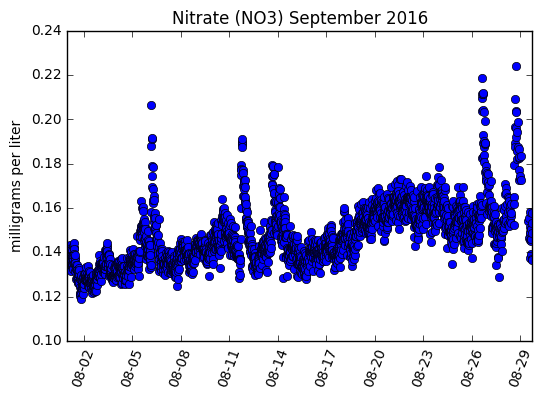

In [35]:
dateFmt = DateFormatter('%m-%d')
fig, ax = plt.subplots()
ax.plot_date(SUNAResultValues.ValueDateTime, SUNAResultValues.DataValue)
ax.xaxis.set_major_formatter(dateFmt)
plt.xticks(rotation=70)
for result in selectedResult:
    plt.title(str(result.variableCode) + ' September 2016')
    plt.ylabel(result.unitsName)


<p>9) Use the numpy libaray to calculate some statistics about the time series</p> 
<p>10) Dynamically create histogram bins based on the time series standard deviation and graph the histogram</p>

maximum of values
15.61105
minimum of values
8.478889
mean value
10.5034952838
standard deviation of values
0.952486090455
standard deviation of values
[7.6460370124299901, 8.1222800576575125, 8.5985231028850357, 9.074766148112559, 9.5510091933400822, 10.027252238567606, 10.503495283795129, 10.979738329022652, 11.455981374250175, 11.932224419477699, 12.408467464705222, 12.884710509932745]


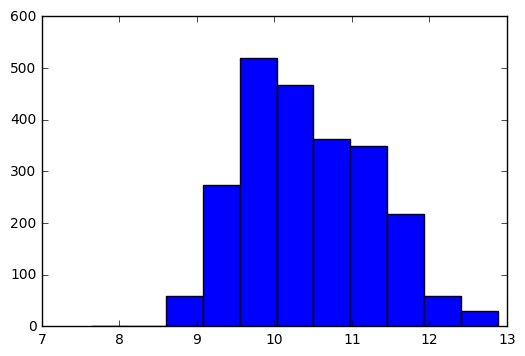

In [24]:
print("maximum of values")
print(numpy.amax(SUNAResultValues.DataValue))
print("minimum of values")
print(numpy.amin(SUNAResultValues.DataValue)) 
print("mean value")
varmean = numpy.mean(SUNAResultValues.DataValue)
print(numpy.mean(SUNAResultValues.DataValue))
print("standard deviation of values")
varstd = numpy.std(SUNAResultValues.DataValue)
print(numpy.std(SUNAResultValues.DataValue)) 
print("standard deviation of values")
varbins = []
for i in range(-6,6):
    varbins.append(varmean + varstd*i*.5)

# histogram = numpy.histogram(wellResultValues.DataValue) #, bins=[101,102,103,104,105,106,107,108,109]
print(varbins)
plt.hist(SUNAResultValues.DataValue, bins=varbins) #[101,102,103,104,105,106,107,108,109]
plt.show()